This notebook demonstrates how to do Meanshift to do image segmentation on an image using the [Scikit-Learn](http://scikit-learn.org/stable/) library.

This is the code that accompanies the article at http://www.chioka.in/meanshift-algorithm-for-the-rest-of-us-python/

In [1]:
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.datasets.samples_generator import make_blobs
from itertools import cycle
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pydicom import read_file
import cv2 as cv
%matplotlib inline
pylab.rcParams['figure.figsize'] = 16, 12

We will load in the image and display the original image for reference.

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


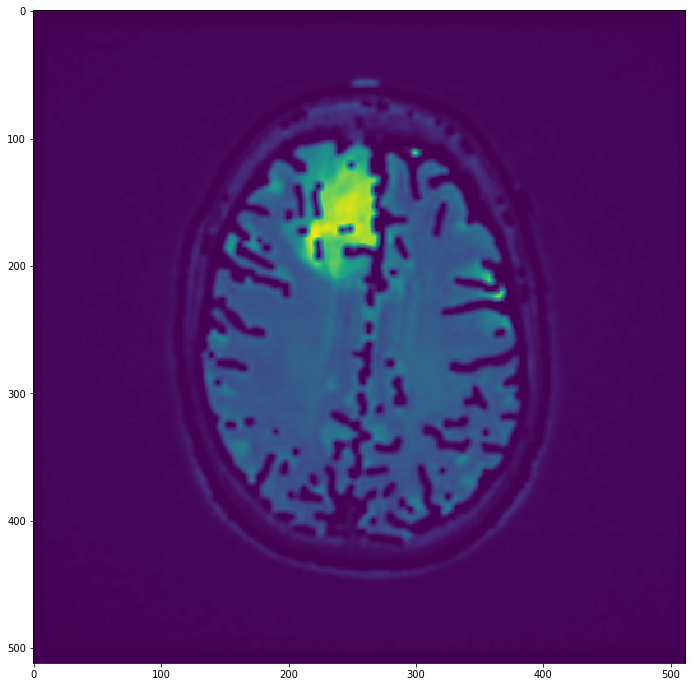

In [26]:
image = read_file('brain.dcm').pixel_array
from scipy.stats import mode

# # Image is (687 x 1025, RGB channels)
# image = np.array(image)
original_shape = image.shape
print(image)

image = (image - np.min(image)) / (np.max(image) - np.min(image))
# edges = cv.Laplacian(image.astype(np.float32), cv.CV_32F)
# edges = (edges - np.min(edges)) / (np.max(edges) - np.min(edges))
dilated = cv.dilate(image, np.ones((5, 5)), iterations=1)
blurred = cv.blur(image, (15, 15))
edges = np.clip(image -  blurred, 0.0, 1.0)
# edges = cv.dilate(edges, np.ones((3, 3)), iterations=1)


edges[edges > 0.1] = 1.0
edges[edges <= 0.1] = 0.0
edges = cv.dilate(edges, np.ones((3, 3)), iterations=1)
image = np.clip(image - edges, 0.0, 1.0)
image = cv.erode(image, np.ones((3, 3)), iterations=1)
image = cv.blur(image, (5, 5))
# Flatten image.
X = np.reshape(image, [-1, 1])
# coords = np.array([[x for x in range(512)] for y in range(512)])
# print(coords)


plt.imshow(image)

Estimate the kernel bandwidth to use from our image (the datapoints).

In [27]:
bandwidth = estimate_bandwidth(X, quantile=0.1, n_samples=100)
print(bandwidth)

0.009137749546279522


Now run Meanshift on the image to do the image segmentation, which is stored in *X*.

In [28]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
# ms = KMeans(n_clusters=4)
# ms.fit(X)

MeanShift(bandwidth=0.009137749546279522, bin_seeding=True, cluster_all=True,
     min_bin_freq=1, n_jobs=1, seeds=None)

Print some debug information to get a sense of what is being done. From what we see, this yielded 6 clusters, thus 6 colors. If you re-run this notebook with different parameters, you may find different results.

In [29]:
labels = ms.labels_
print(labels.shape)
cluster_centers = ms.cluster_centers_
tumor_i = np.argmax(ms.cluster_centers_)
print(cluster_centers.shape)

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

(262144,)
(22, 1)
number of estimated clusters : 22


In [42]:
labels = np.reshape(labels, original_shape).astype(np.uint8)  # Just take size, ignore RGB channels.
# segmented_image = image
# segmented_image[labels == tumor_i] = 1
# segmented_image[labels != tumor_i] = 0
segmented_image = cv.dilate(labels, np.ones((3, 3)), iterations=1)


Now, let's display the segmented image and the original image.

(-0.5, 511.5, 511.5, -0.5)

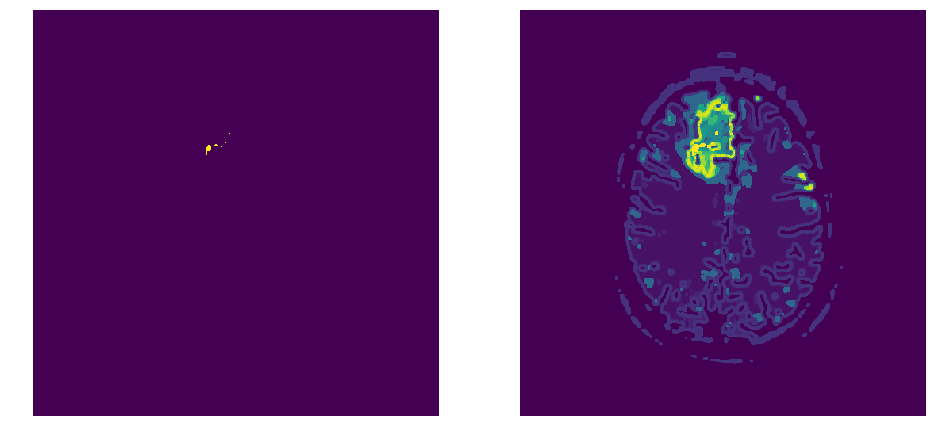

In [43]:
plt.figure(2)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.axis('off')

In [4]:
%%timeit
cv.blur(image, (15, 15))

1.11 ms ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
